In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
file_path='/content/drive/MyDrive/Kidney_segmentation_data/'

Mounted at /content/drive/


In [ ]:
import os
from glob import glob
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import albumentations as A
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dense
#from keras.layers import Flatten
from keras.layers import AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Lambda
physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
from sklearn.preprocessing import StandardScaler
import math


In [ ]:
def Augmentation(images,mask):
    def _transform(image,mask):
        transform=A.Compose([
         A.HorizontalFlip(p=0.25),
         A.VerticalFlip(p=0.25),
         A.RandomRotate90(p=.5),
         A.RandomContrast(limit=0.2, p=0.1),
         A.Transpose(p=0.5),
         A.ElasticTransform(p=.4, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    ])
        aug=transform(image=image,mask=mask)
        img=aug['image']
        img=tf.cast(img,tf.float64)
        msk=aug['mask']
        msk=tf.cast(msk,tf.float64)
#         print("after augmentation",img.shape,msk.shape)
        return img,msk
    image,mask=tf.numpy_function(_transform,[images,mask],[tf.float64,tf.float64])
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    mask.set_shape([IMAGE_SIZE, IMAGE_SIZE, 2])
    return image,mask

In [ ]:
IMAGE_SIZE=256
AUTO = tf.data.experimental.AUTOTUNE
def load_data(image_path,split=0.3):
    if image_path=="train_256/*png":
      images=sorted(glob(file_path + image_path))
    else:
      images = sorted(glob(file_path + image_path), key=lambda x: int(x.split("/")[-1].split(".")[0]))

    masks = sorted(glob(file_path+"masks_256/*"))
    total_size = len(images)
    valid_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=split, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split, random_state=42)

    valid_x, test_x = train_test_split(valid_x, test_size=split, random_state=42)
    valid_y, test_y = train_test_split(valid_y, test_size=split, random_state=42)

    return (train_x, train_y), (valid_x, valid_y),(test_x,test_y)
(train_x,train_y),(valid_x,valid_y),(test_x,test_y)=load_data(image_path="train_256/*png")
(train_x,train_y),(valid_x,valid_y),(test_individual_x,test_individual_y)=load_data(image_path="individual_256/*jpg")
(train_x,train_y),(valid_x,valid_y),(test_batch_256_x,test_batch_256_y)=load_data(image_path="batch_256/*jpg")
(train_x,train_y),(valid_x,valid_y),(test_batch_500_256_x,test_batch_500_256_y)=load_data(image_path="batch_500_256/*jpg")


train_size=len(train_x)
valid_size=len(valid_x)



def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(256,256),interpolation=cv2.INTER_AREA)
    x = x/255.0
    x=tf.cast(x,dtype=tf.float64)
    return x
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(256,256),interpolation=cv2.INTER_NEAREST)
    x = np.expand_dims(x, axis=-1)
    x = np.concatenate([x,x],axis=-1)
    x=tf.cast(x,dtype=tf.float64)
    return x

def parser(x,y):
    def _parse(x,y):
        x=read_image(x)
        y=read_mask(y)
        return x,y
    x,y = tf.numpy_function(_parse, [x,y], [tf.float64,tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 2])
    return x,y
    
def tf_dataset(x, y, batch,repeat_original=1):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(parser)
    original_dataset = dataset.repeat(repeat_original)

    augmented_dataset = dataset.map(Augmentation)
    dataset = tf.data.Dataset.concatenate(original_dataset, augmented_dataset)
    # dataset = dataset.repeat()
    dataset = dataset.shuffle(128,seed=0)
    dataset = dataset.batch(batch)
    return dataset

test_dataset=tf_dataset(test_x,test_y,batch=8)
test_dataset_individual=tf_dataset(test_individual_x,test_individual_y,batch=8)
test_dataset_batch=tf_dataset(test_batch_256_x,test_batch_256_y,batch=8)
test_dataset_batch500=tf_dataset(test_batch_500_256_x,test_batch_500_256_y,batch=8)

IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_CHANNELS=3

In [ ]:
#LOSS FUNCTIONS 
from tensorflow.keras.losses import binary_crossentropy
smooth = 1
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)



In [ ]:
baseline_model=tf.keras.models.load_model(file_path+"weights/"+"ninth_model.hd5",custom_objects={
        'dice_loss': dice_loss ,'dice_coef': dice_coef})
model_individual=tf.keras.models.load_model(file_path+"individual/"+"ninth_model.hd5",custom_objects={
        'dice_loss': dice_loss ,'dice_coef': dice_coef})
model_batch50=tf.keras.models.load_model(file_path+"batch/"+"eleventh_model.hd5",custom_objects={
        'dice_loss': dice_loss ,'dice_coef': dice_coef})
model_batch500=tf.keras.models.load_model(file_path+"batch_500/"+"seventh_model.hd5",custom_objects={
        'dice_loss': dice_loss ,'dice_coef': dice_coef})

1/1 [==============================] - 1s 1s/step


(-0.5, 255.5, 255.5, -0.5)

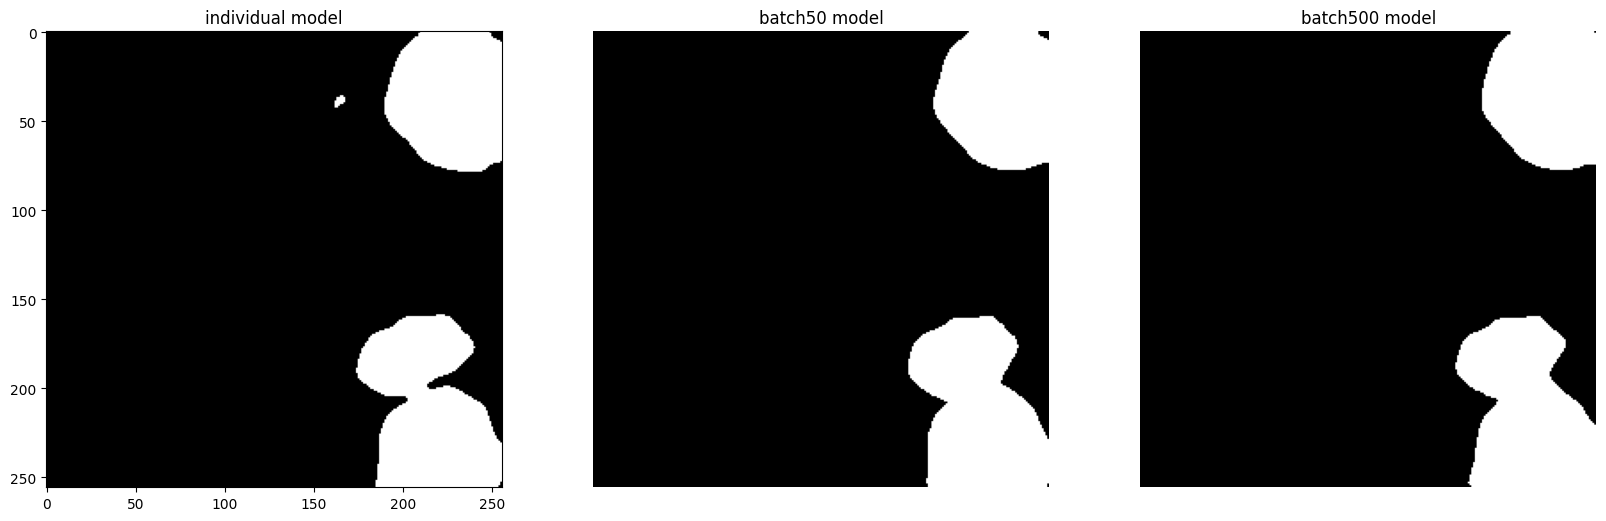

In [ ]:

#### case of plotting corresponding reduced image for corresponding use cases
x_individual=['/content/drive/MyDrive/Kidney_segmentation_data/individual_256/6708.jpg']
y_individual=['/content/drive/MyDrive/Kidney_segmentation_data/individual_256/6708.jpg']
x_batch_50=['/content/drive/MyDrive/Kidney_segmentation_data/batch_256/6708.jpg']
y_batch_50=['/content/drive/MyDrive/Kidney_segmentation_data/batch_256/6708.jpg']
x_batch_500=['/content/drive/MyDrive/Kidney_segmentation_data/batch_500_256/6708.jpg']
y_batch_500=['/content/drive/MyDrive/Kidney_segmentation_data/batch_500_256/6708.jpg']


image_individual,masks_individual=tf_dataset(x_individual,y_individual,batch=1)
image_batch_50,masks_batch_50=tf_dataset(x_batch_50,y_batch_50,batch=1)
image_batch_500,masks_batch_500=tf_dataset(x_batch_500,y_batch_500,batch=1)

predicted_mask_individual=model_individual.predict(image_individual[0])
predicted_mask_batch50=model_batch50.predict(image_batch_50[0])
predicted_mask_batch500=model_batch500.predict(image_batch_500[0])

predicted_mask_individual = (predicted_mask_individual > 0.5).astype(np.uint8)
predicted_mask_batch50 = (predicted_mask_batch50 > 0.5).astype(np.uint8)
predicted_mask_batch500 = (predicted_mask_batch500 > 0.5).astype(np.uint8)

for i in range(predicted_mask_individual.shape[0]):
  predicted_mask_individual_i=np.max(predicted_mask_individual[i],axis=-1)
  predicted_mask_individual_i = predicted_mask_individual_i * 255

for i in range(predicted_mask_batch50.shape[0]):
    predicted_mask_batch50_i=np.max(predicted_mask_batch50[i],axis=-1)
    predicted_mask_batch50_i = predicted_mask_batch50_i * 255

for i in range(predicted_mask_batch500.shape[0]):
    predicted_mask_batch500_i=np.max(predicted_mask_batch500[i],axis=-1)
    predicted_mask_batch500_i = predicted_mask_batch500_i * 255



# Plot the original image, mask, and predicted mask

plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(predicted_mask_individual_i, cmap="gray")
plt.title("individual model")



plt.subplot(1, 3, 2)
plt.imshow(predicted_mask_batch50_i, cmap="gray")
plt.title("batch50 model")
plt.axis("off")


plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_batch500_i, cmap="gray")
plt.title("batch500 model")
plt.axis("off")
plt.axis("off")

In [ ]:
import matplotlib.image as mpimg

#Visualizing the PCs after dimensionality reduction
image_path=[
            '/content/drive/MyDrive/Kidney_segmentation_data/train_256/afa5e8098_0288.png',
            '/content/drive/MyDrive/Kidney_segmentation_data/individual_256/5404.jpg',
            '/content/drive/MyDrive/Kidney_segmentation_data/batch_256/5404.jpg',
            '/content/drive/MyDrive/Kidney_segmentation_data/batch_500_256/5404.jpg',
            '/content/drive/MyDrive/Kidney_segmentation_data/train_256/4ef6695ce_0882.png',
            '/content/drive/MyDrive/Kidney_segmentation_data/individual_256/3264.jpg',
            '/content/drive/MyDrive/Kidney_segmentation_data/batch_256/3264.jpg',
            '/content/drive/MyDrive/Kidney_segmentation_data/batch_500_256/3264.jpg']
for i in range(2):
  i=i*4
  img=image_path[i:i+4]
  plt.figure(figsize=(20, 20))
  plt.subplot(1, 4, 1)
  image = mpimg.imread(img[0])
  # Display the image
  plt.title("Original Image")
  plt.imshow(image)
  plt.subplot(1, 4, 2)
  image = mpimg.imread(img[1])
  plt.title("PCs (individual image level)")
  # Display the image
  plt.imshow(image)
  plt.subplot(1, 4, 3)
  image = mpimg.imread(img[2])
  plt.title("PCs (batch of 50)")
  # Display the image
  plt.imshow(image)
  plt.subplot(1, 4, 4)
  image = mpimg.imread(img[3])
  plt.title("PCs (batch of 500)")
  # Display the image
  plt.imshow(image)
  plt.axis("off")


In [ ]:
#considering 15 batches for prediction
image_baseline=[]
mask_baseline=[]
image_individual=[]
mask_individual=[]
image_batch50=[]
mask_batch50=[]
image_batch500=[]
mask_batch500=[]
count=0
for  image,mask in test_dataset:
  image_baseline.append(image)
  mask_baseline.append(mask)
  count=count+1
  if count>5:
    break

count=0
for  image,mask in test_dataset_individual:
  image_individual.append(image)
  count=count+1
  if count>5:
    break

count=0
for  image,mask in test_dataset_batch:
  image_batch50.append(image)
  count=count+1
  if count>5:
    break

count=0
for  image,mask in test_dataset_batch500:
  image_batch500.append(image)
  count=count+1
  if count>5:
    break




1/1 [==============================] - 16s 16s/step


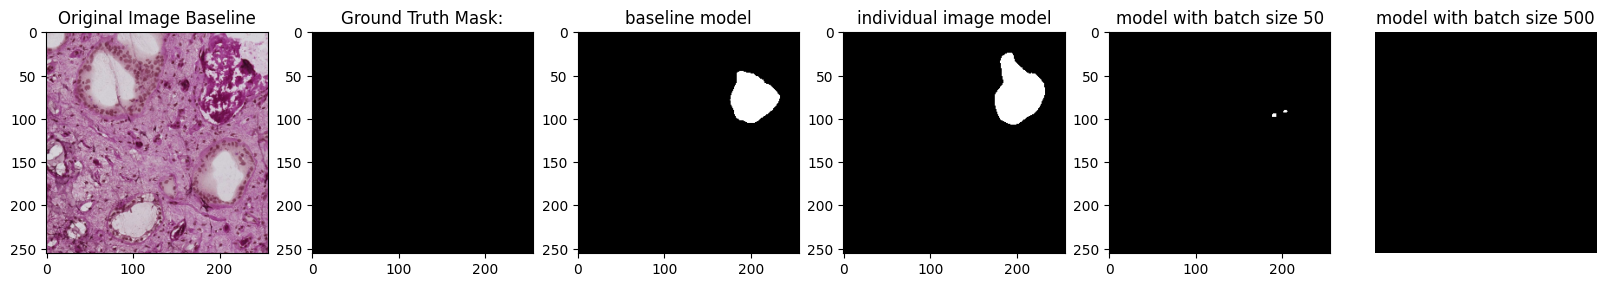

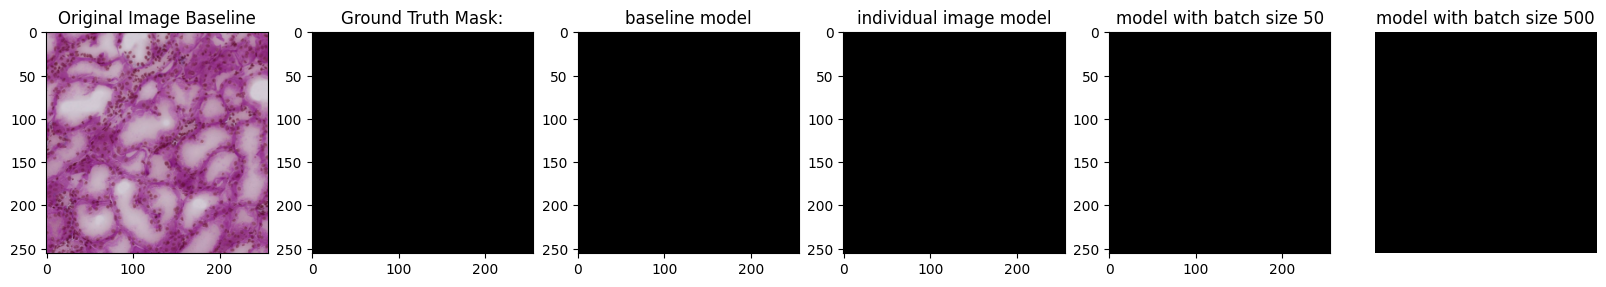

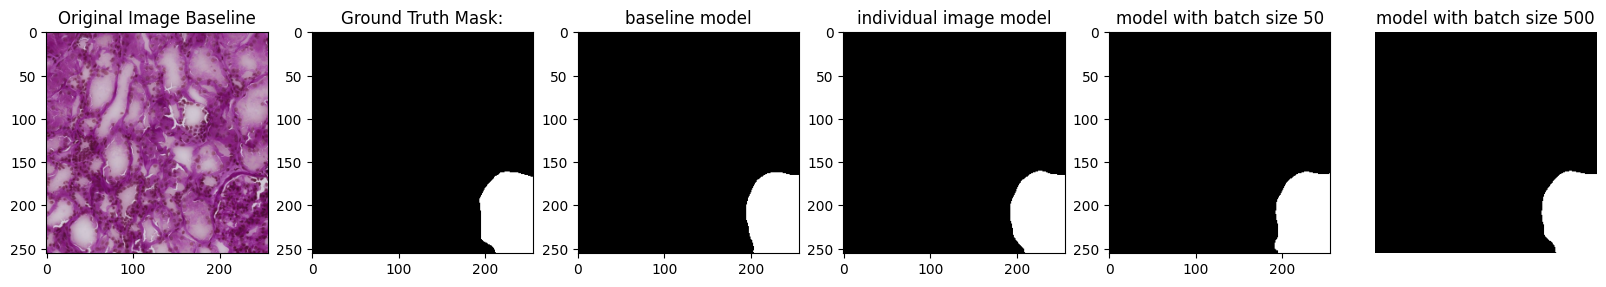

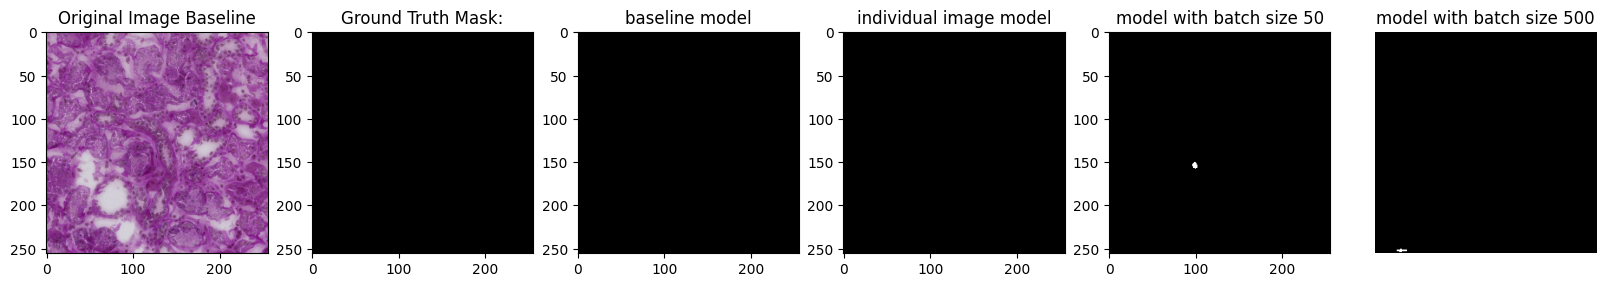

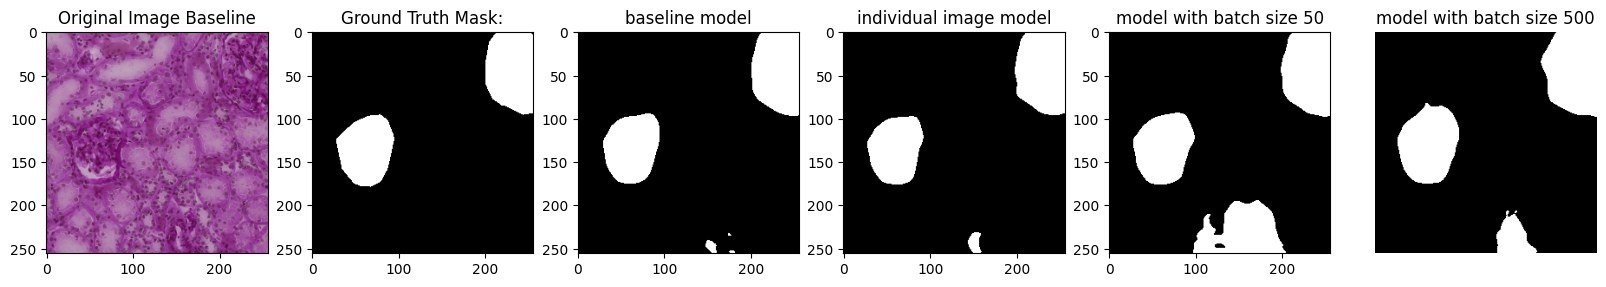

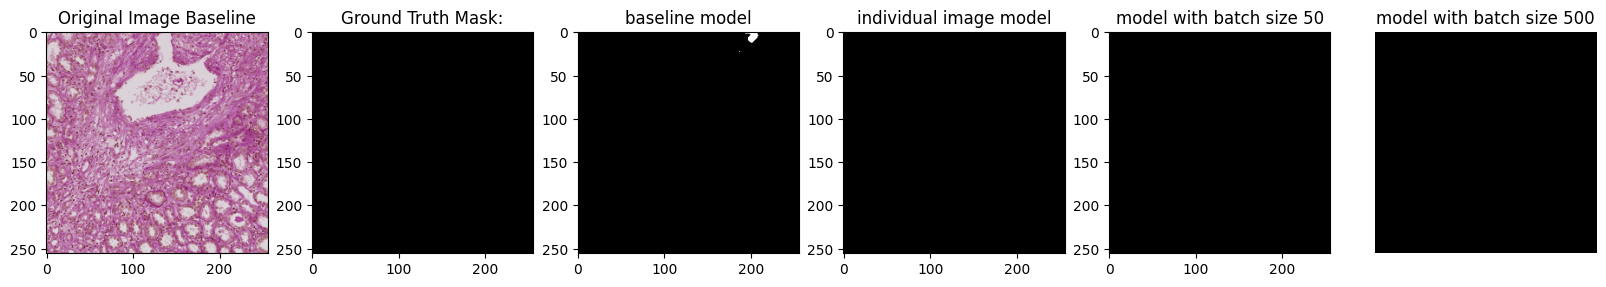

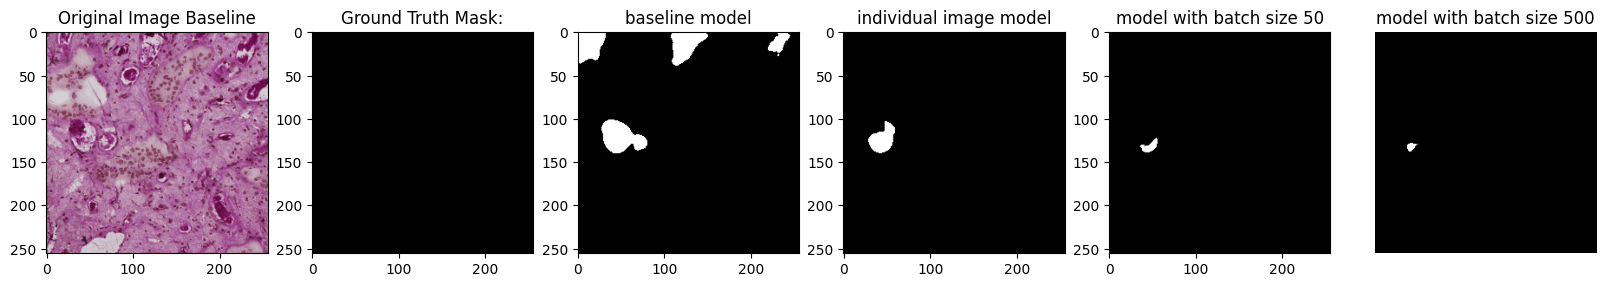

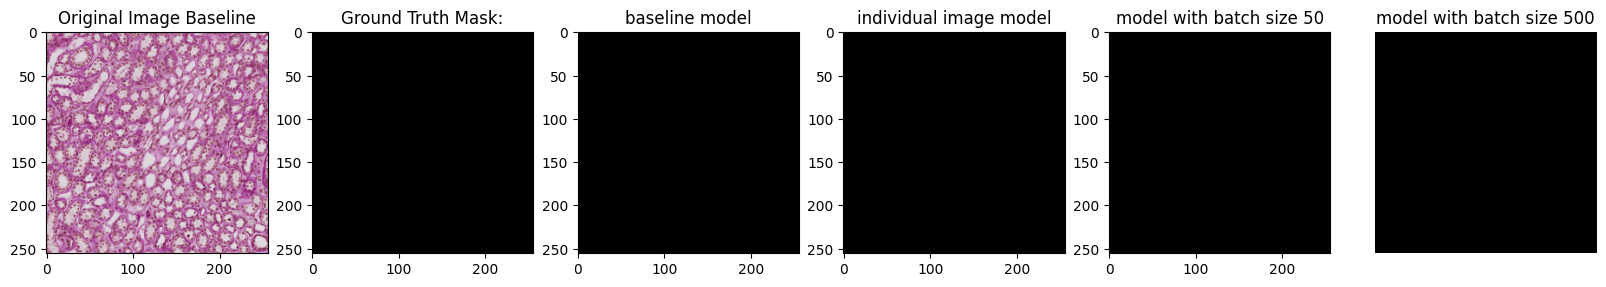

1/1 [==============================] - 9s 9s/step


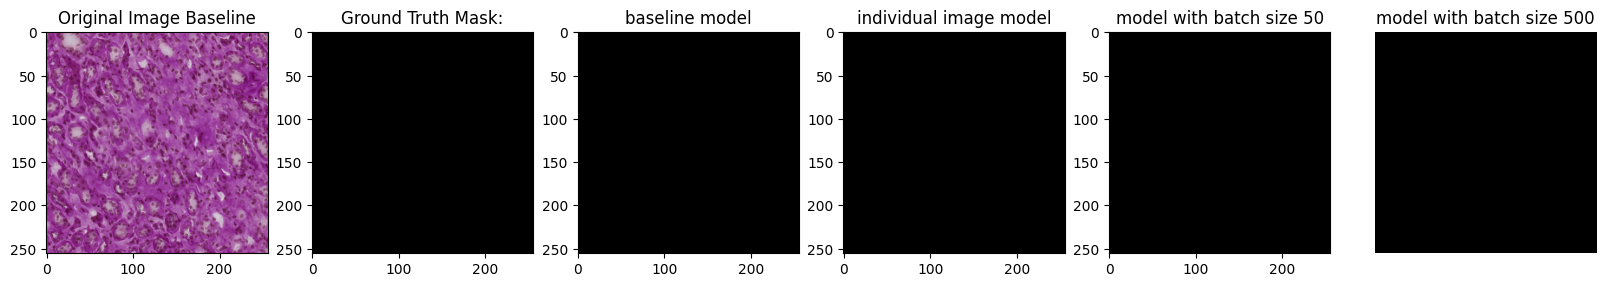

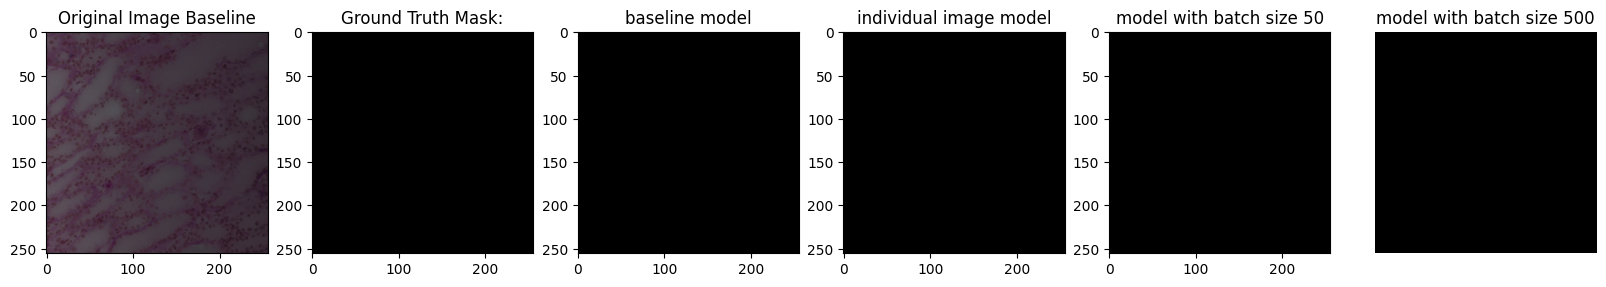

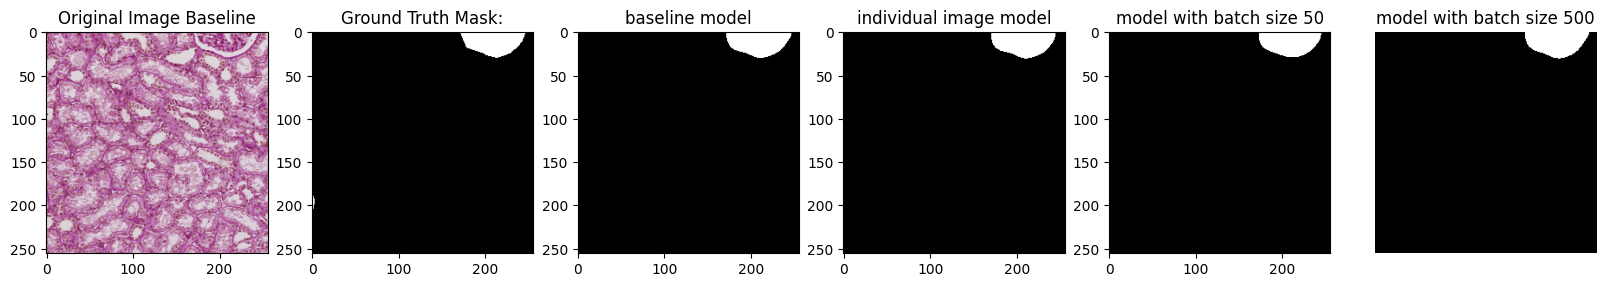

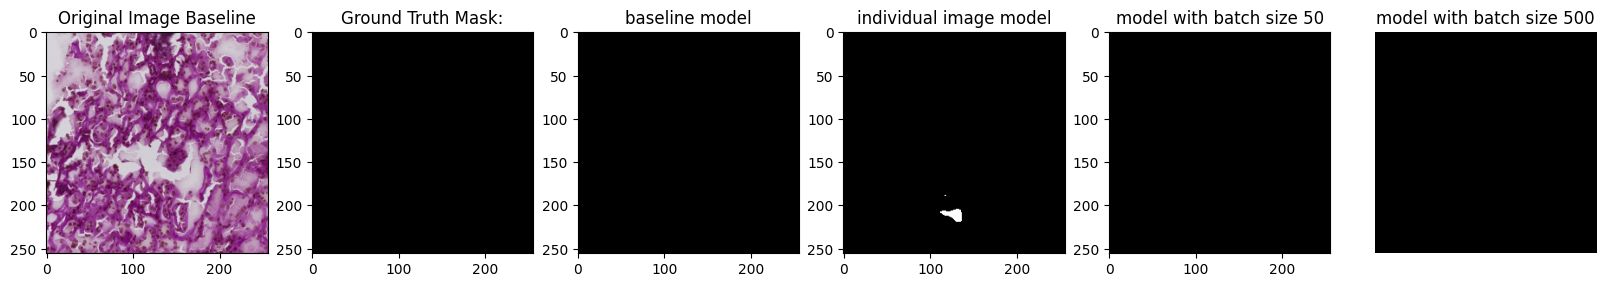

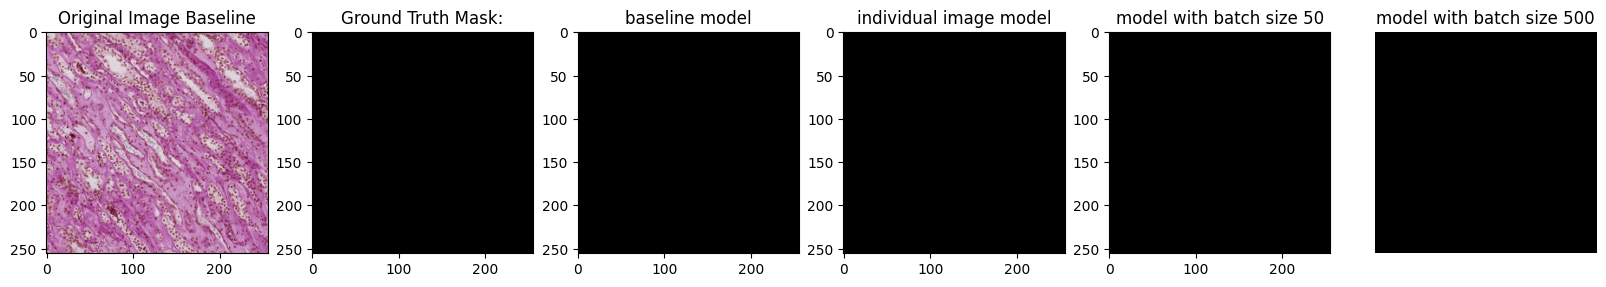

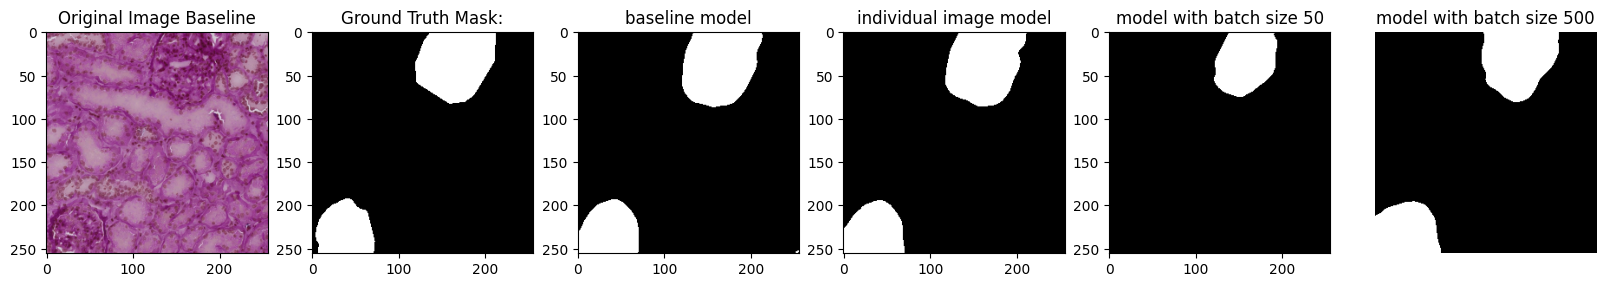

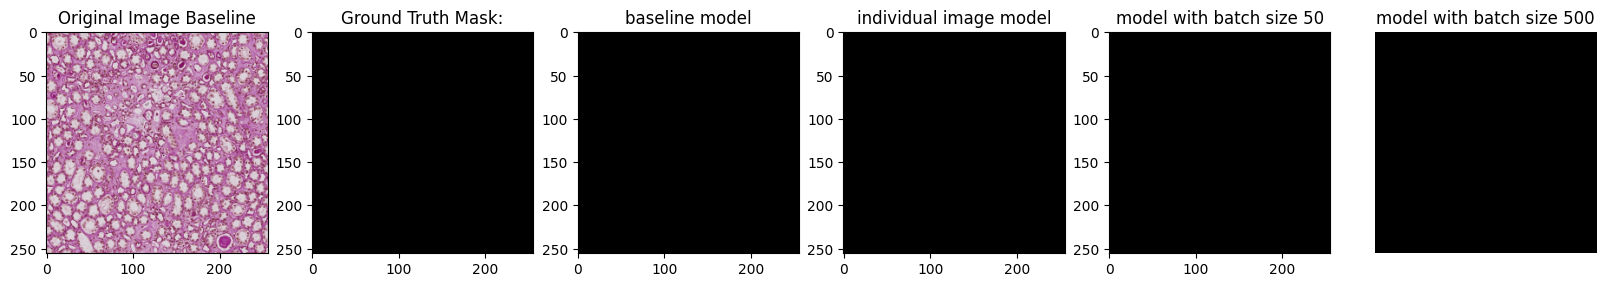

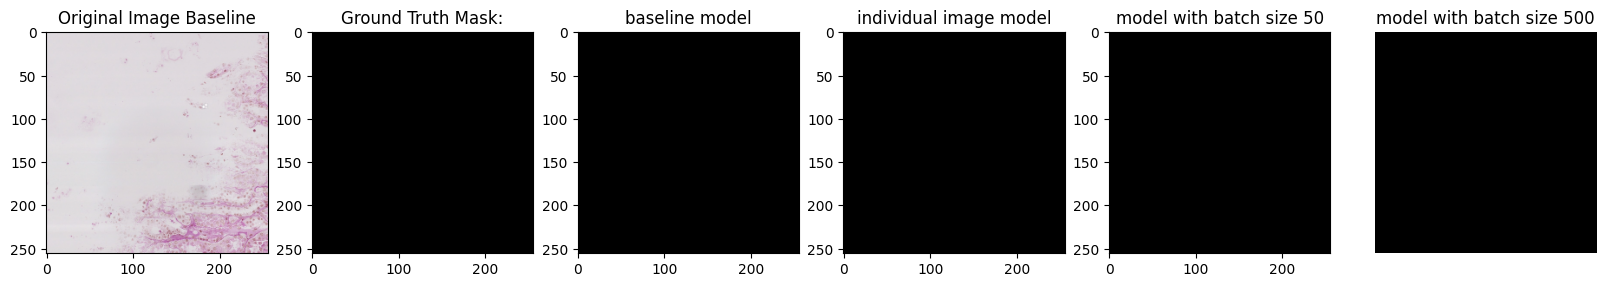

1/1 [==============================] - 9s 9s/step


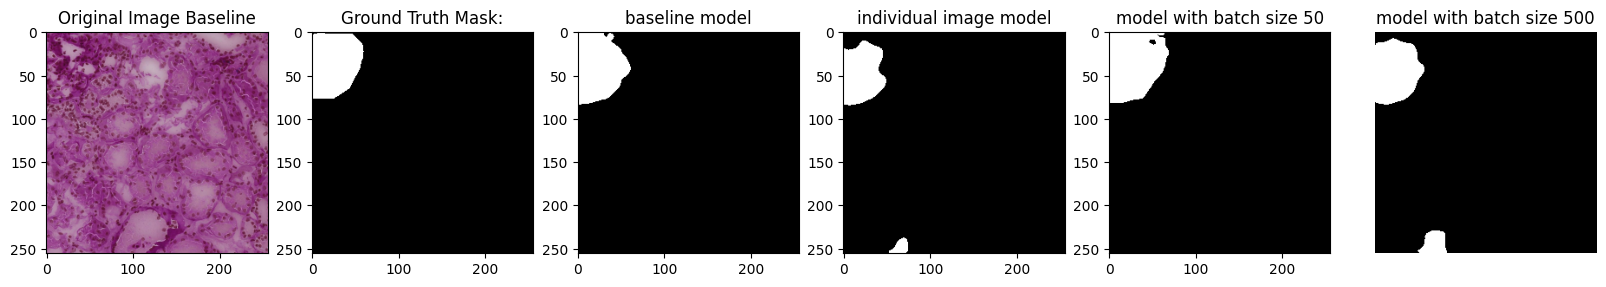

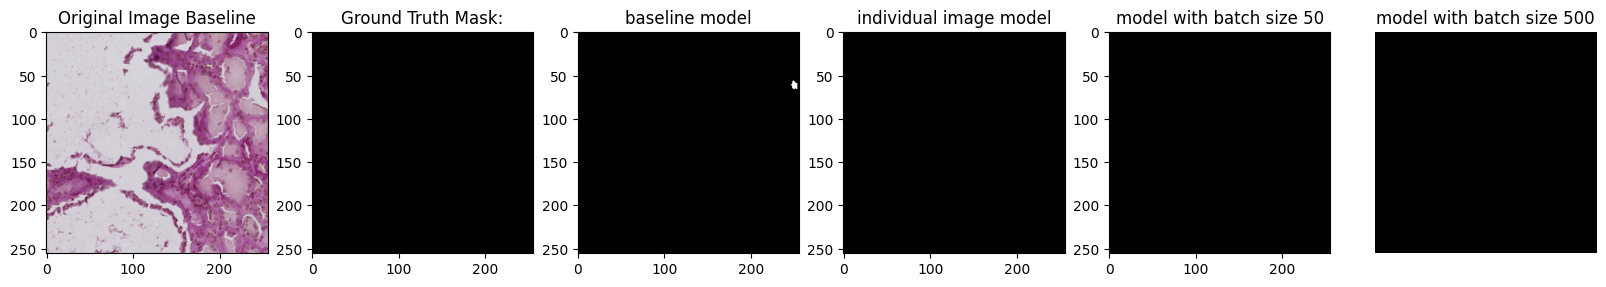

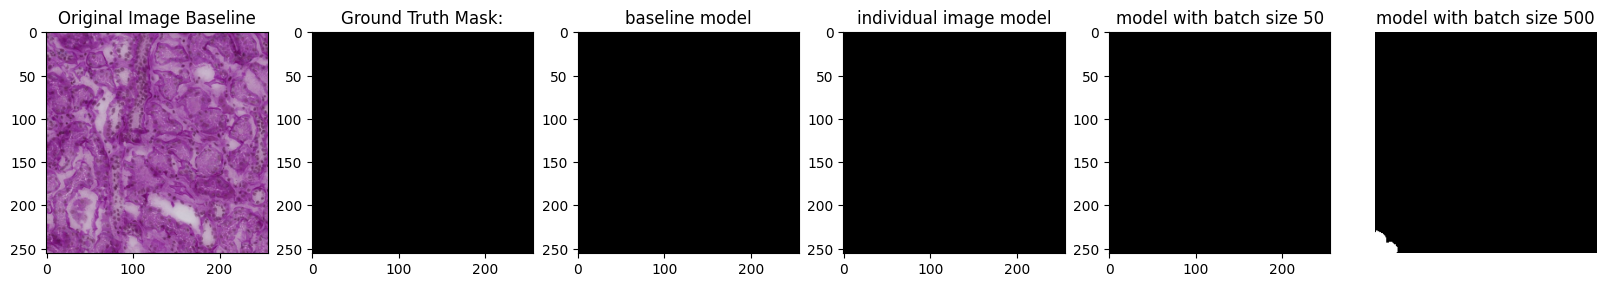

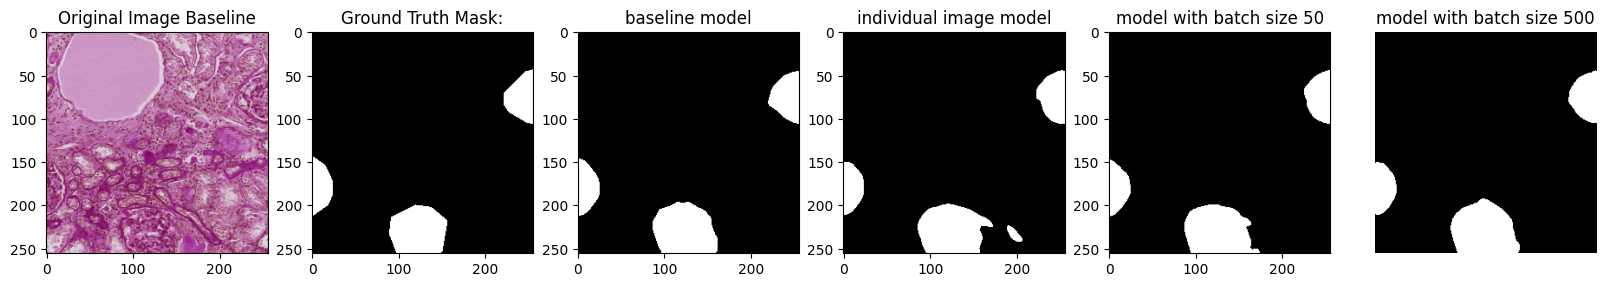

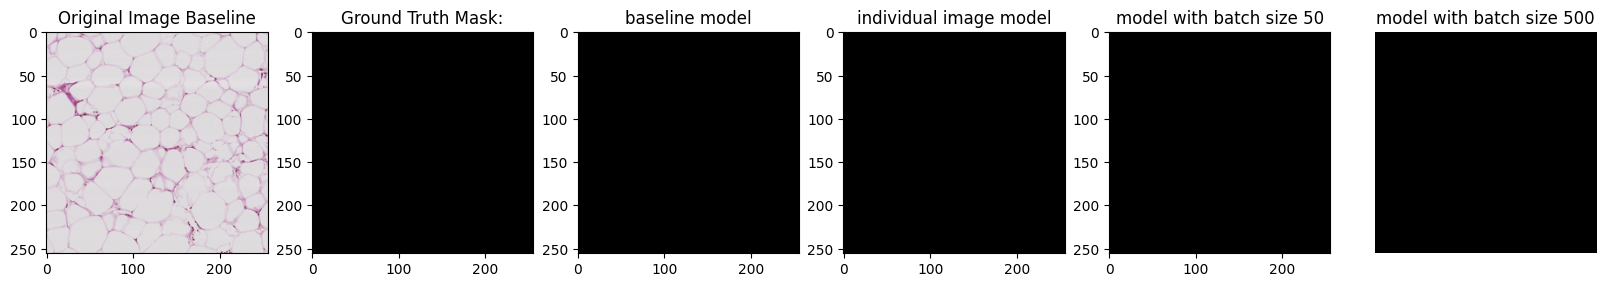

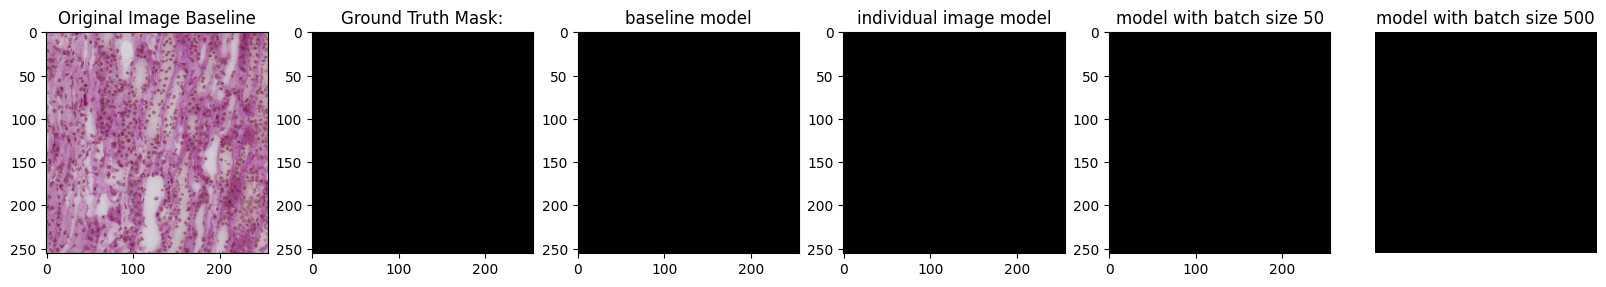

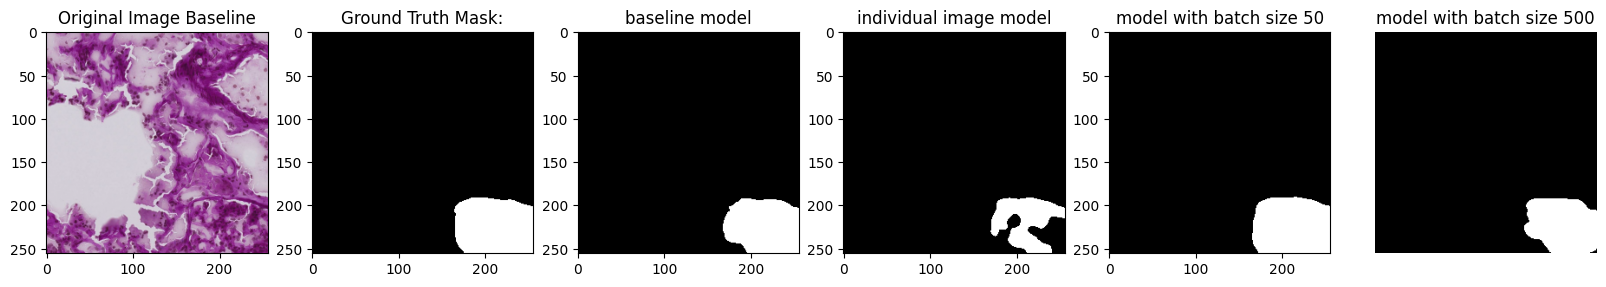

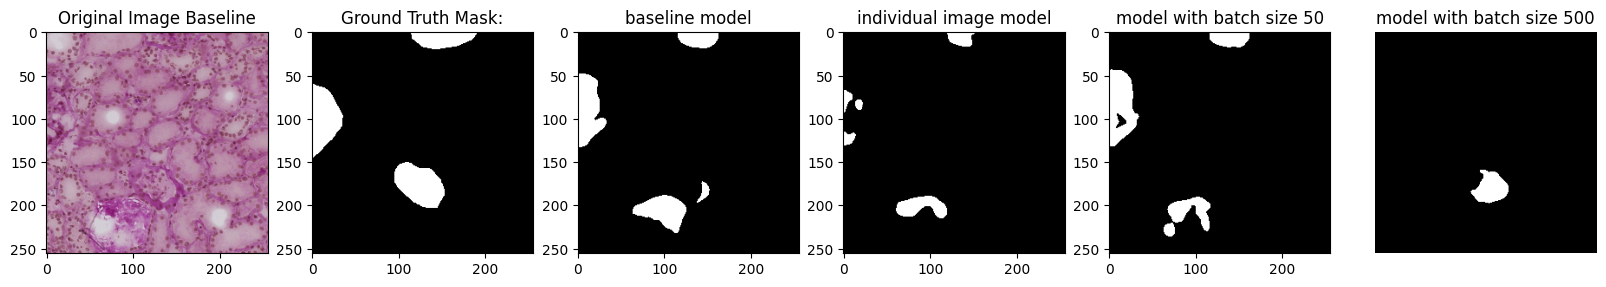

1/1 [==============================] - 9s 9s/step


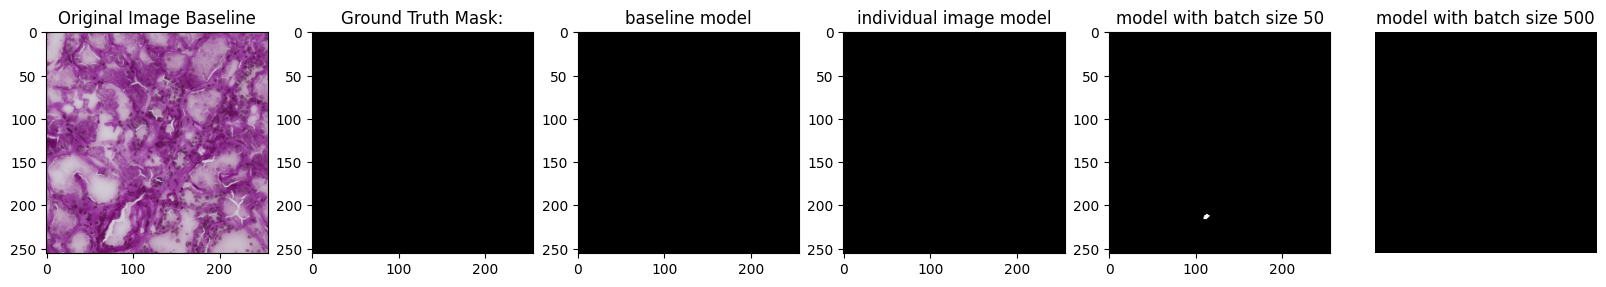

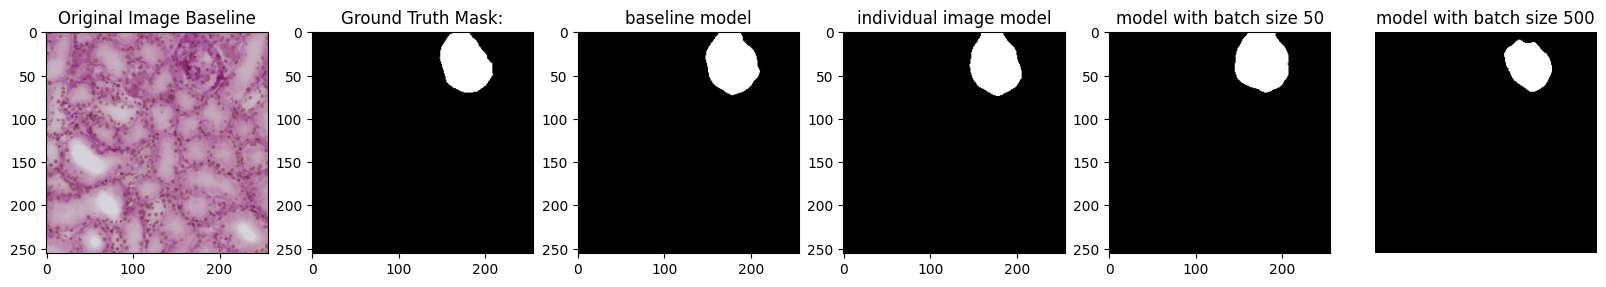

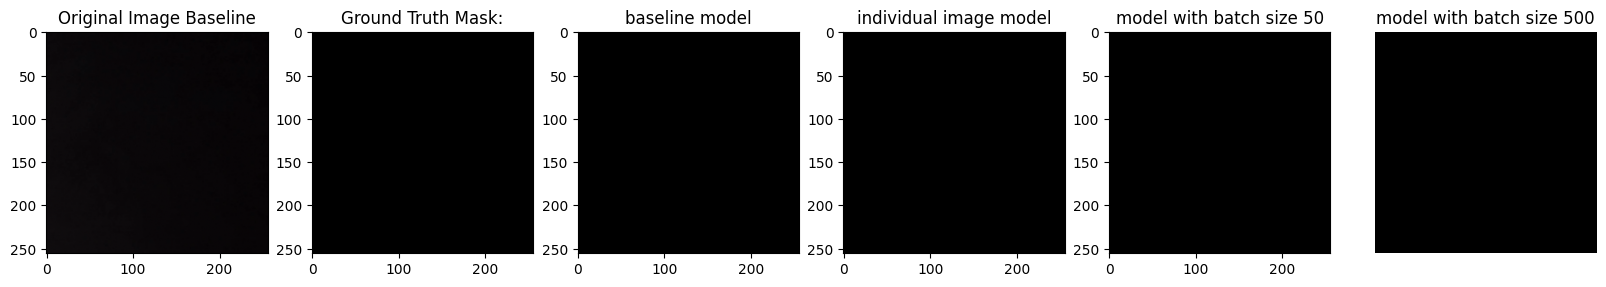

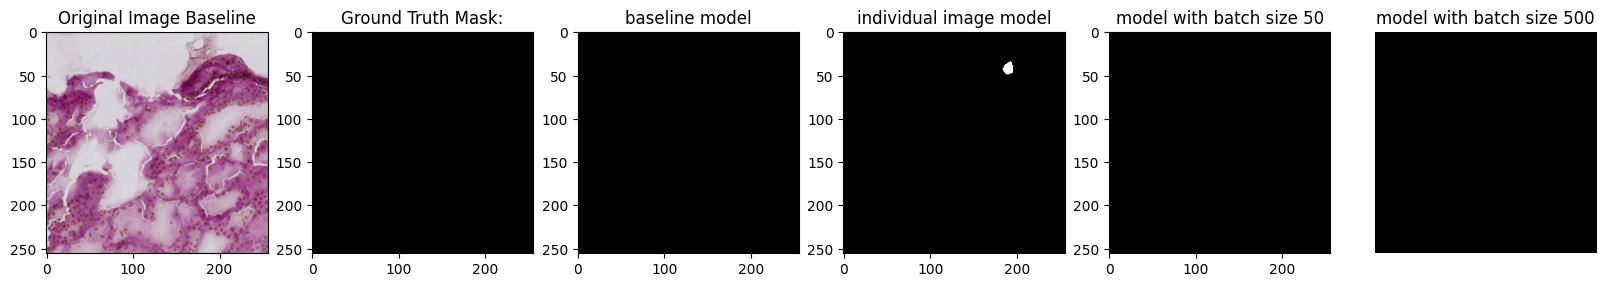

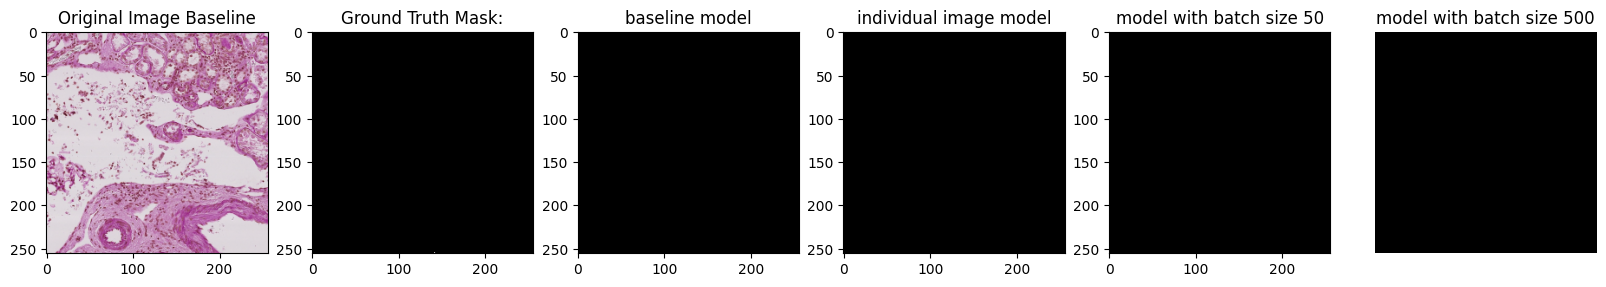

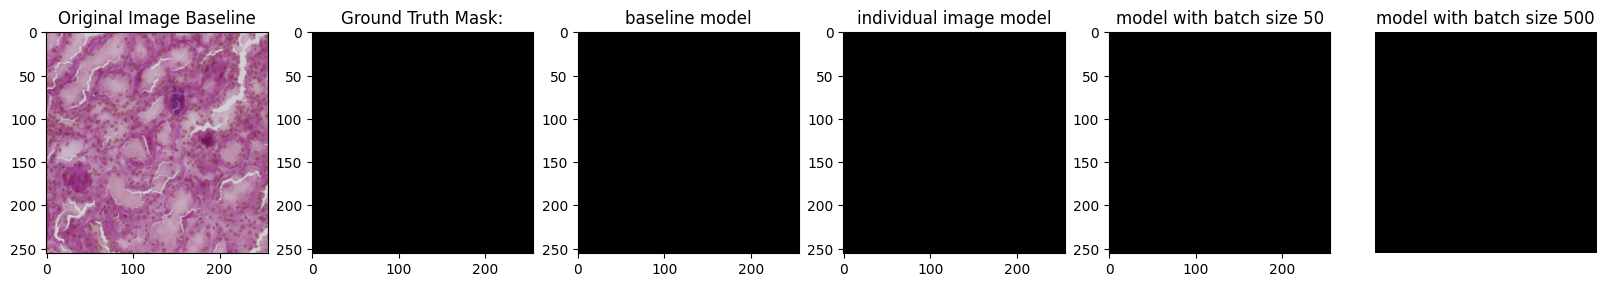

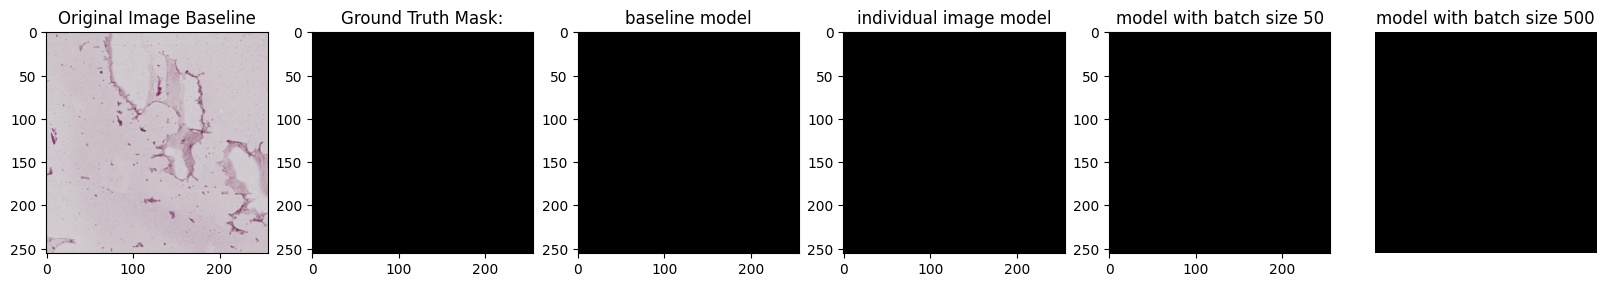

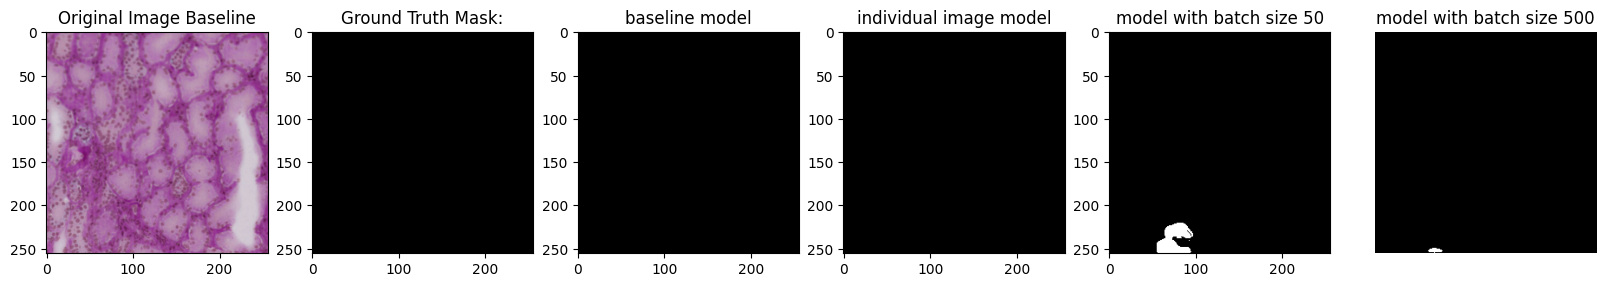

1/1 [==============================] - 9s 9s/step


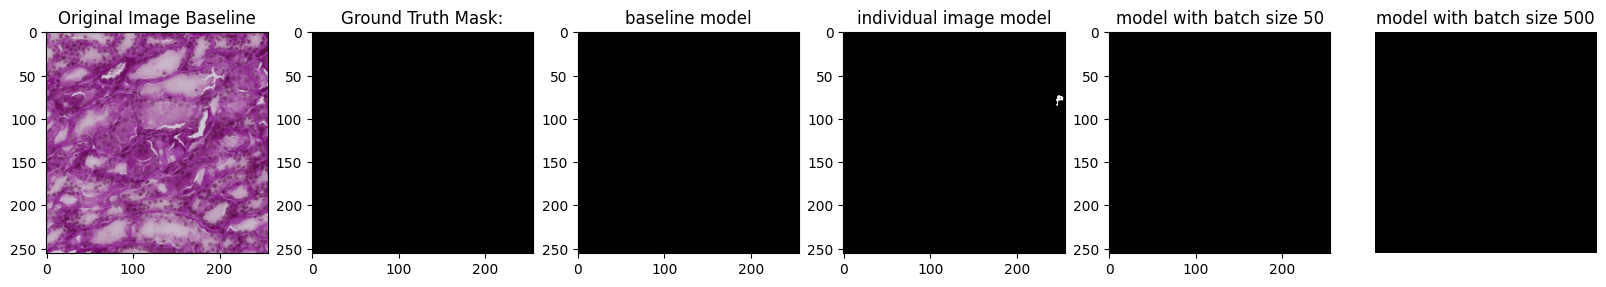

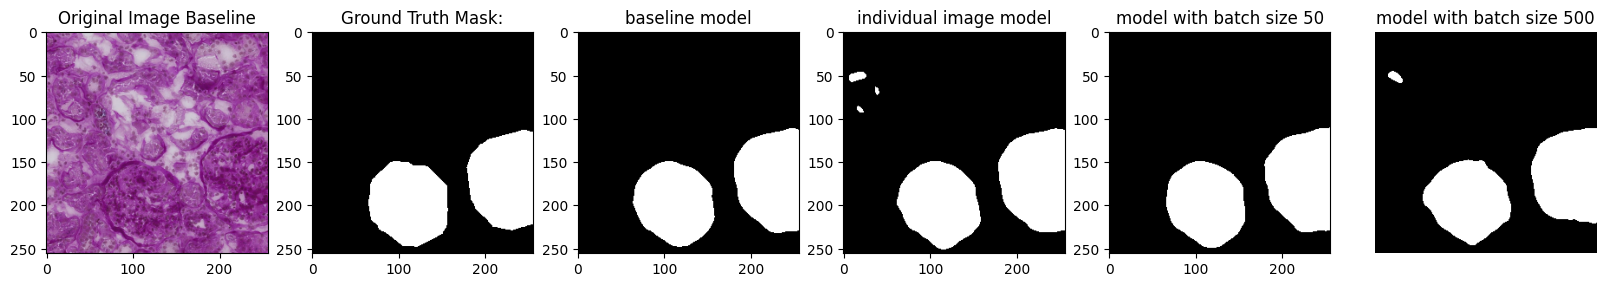

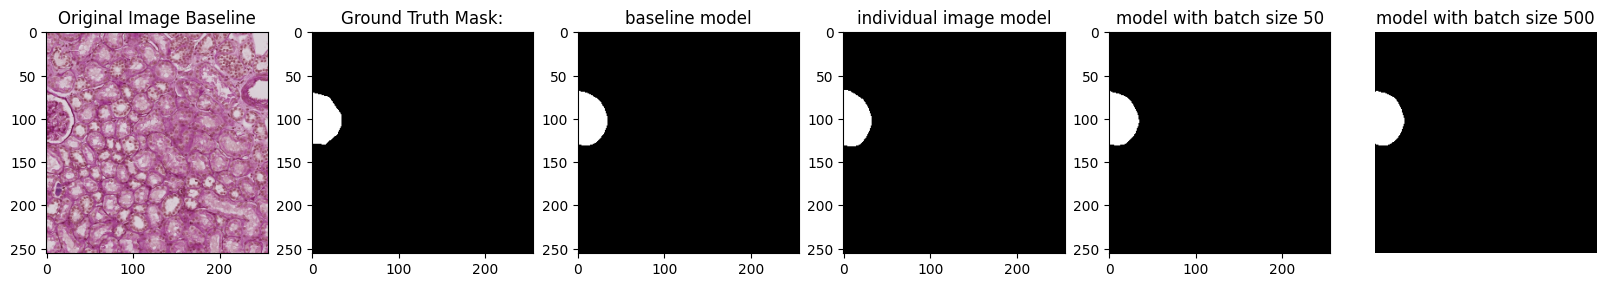

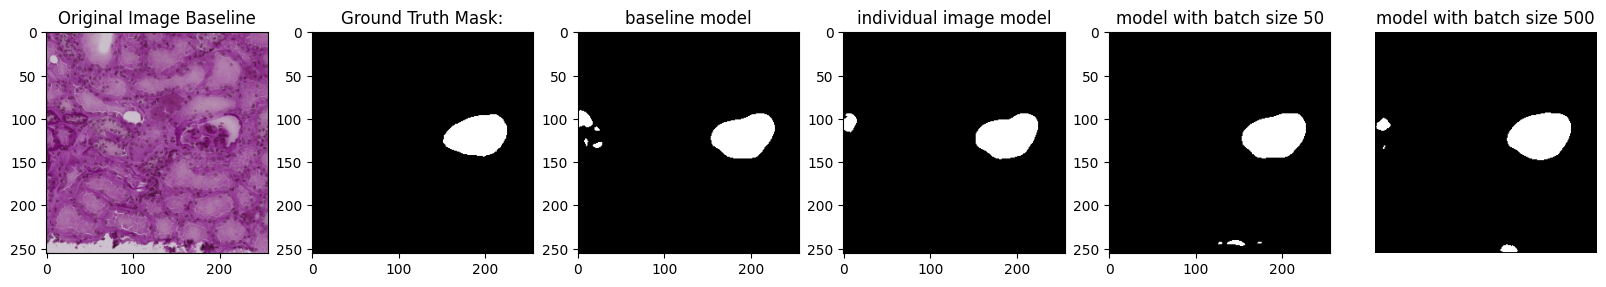

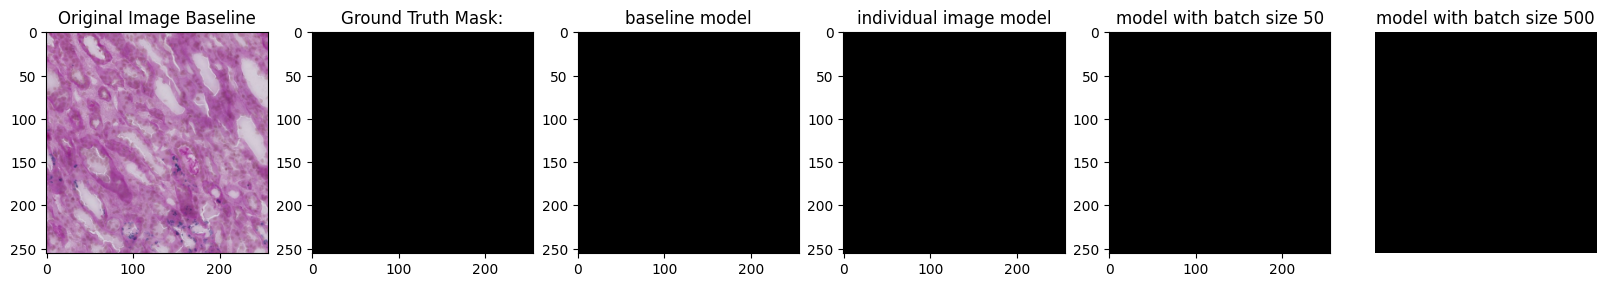

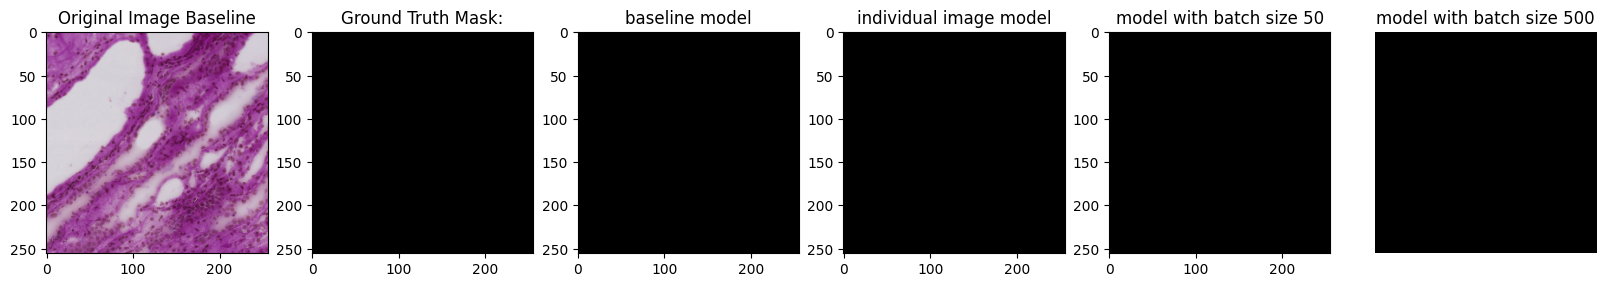

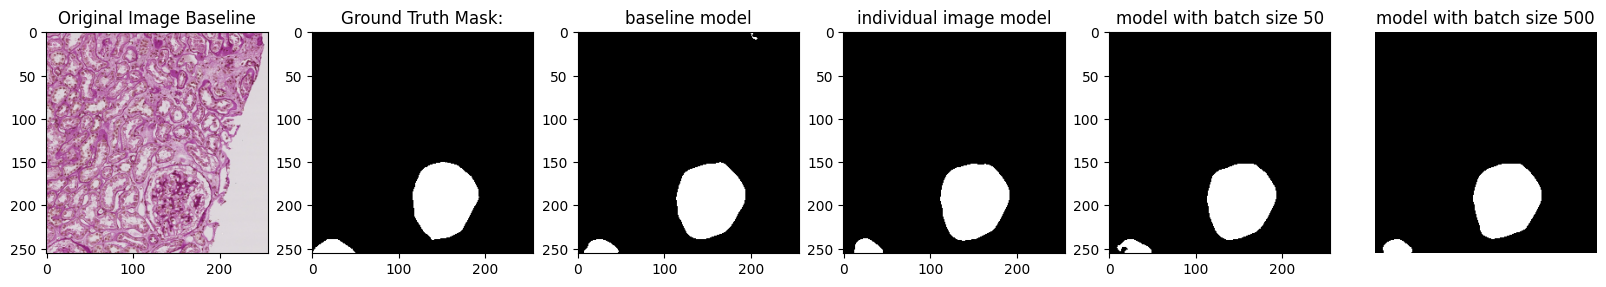

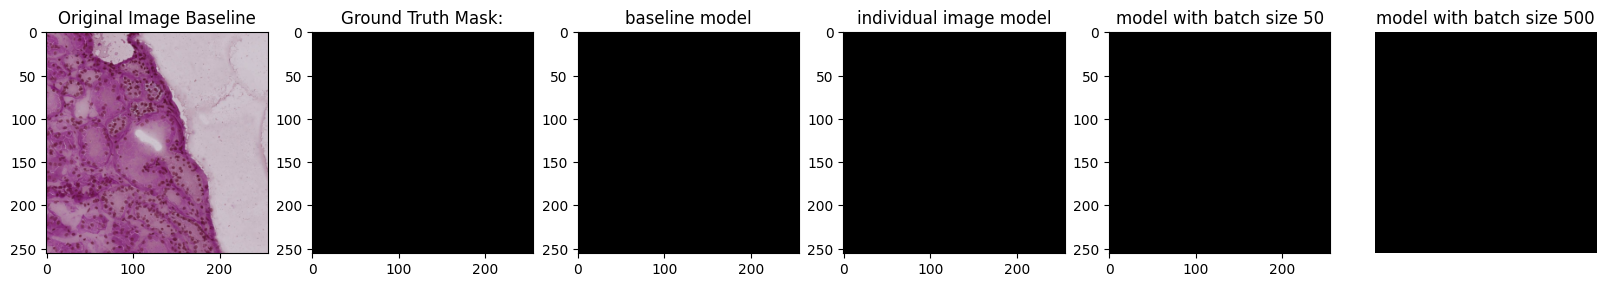

1/1 [==============================] - 10s 10s/step


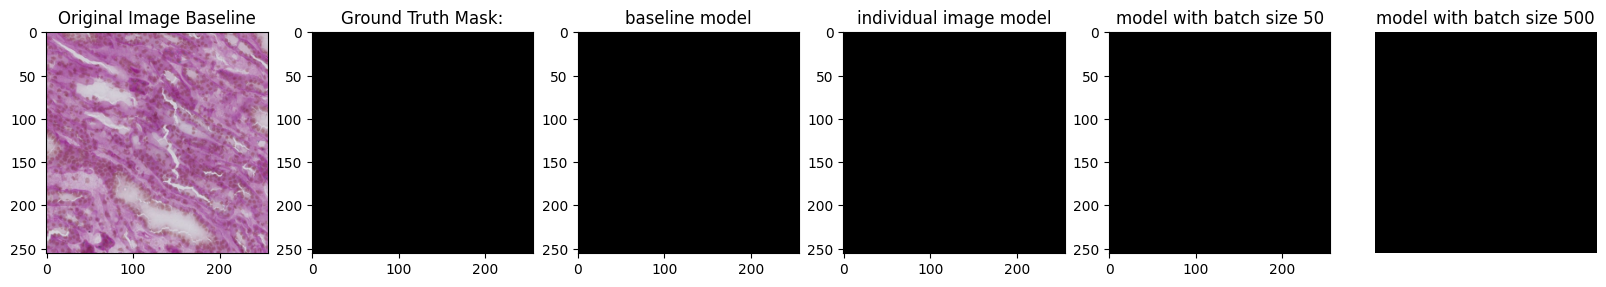

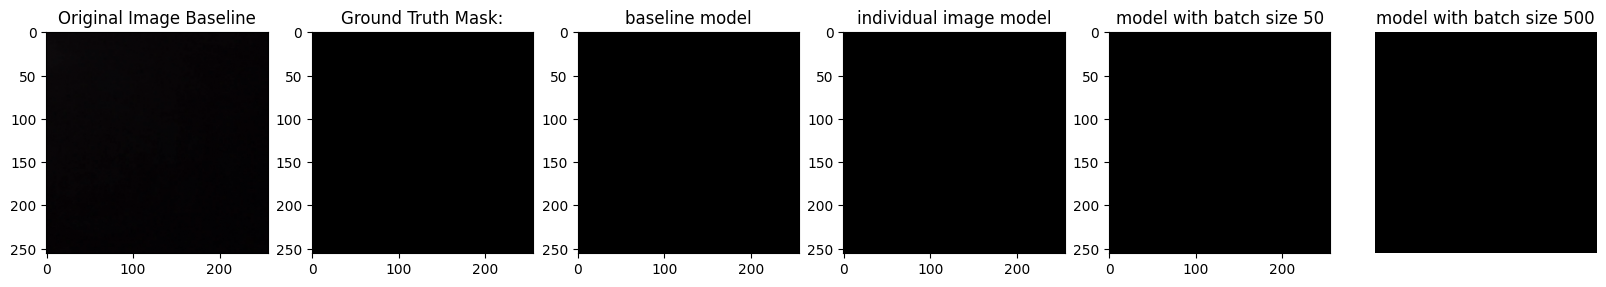

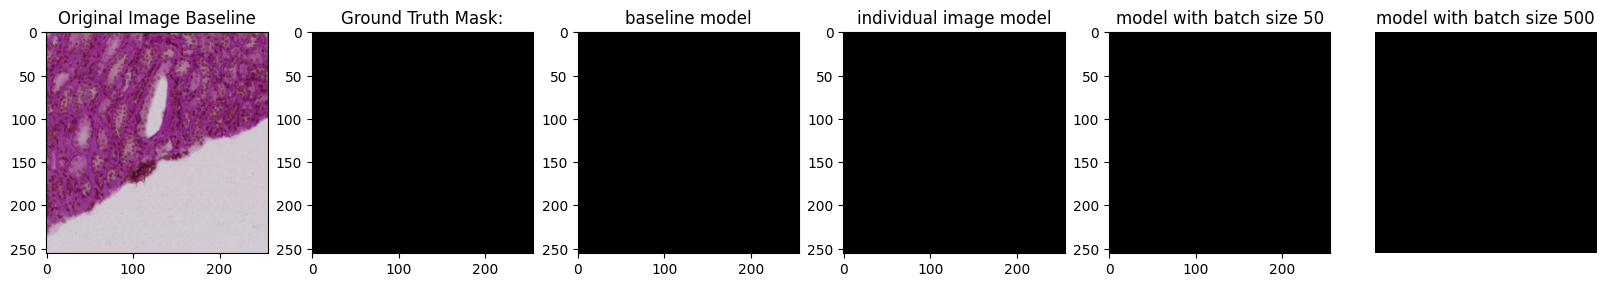

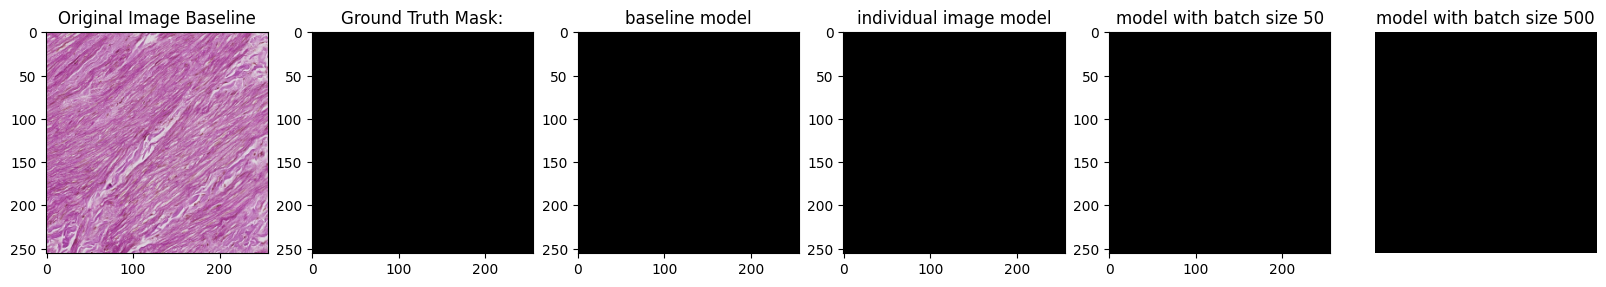

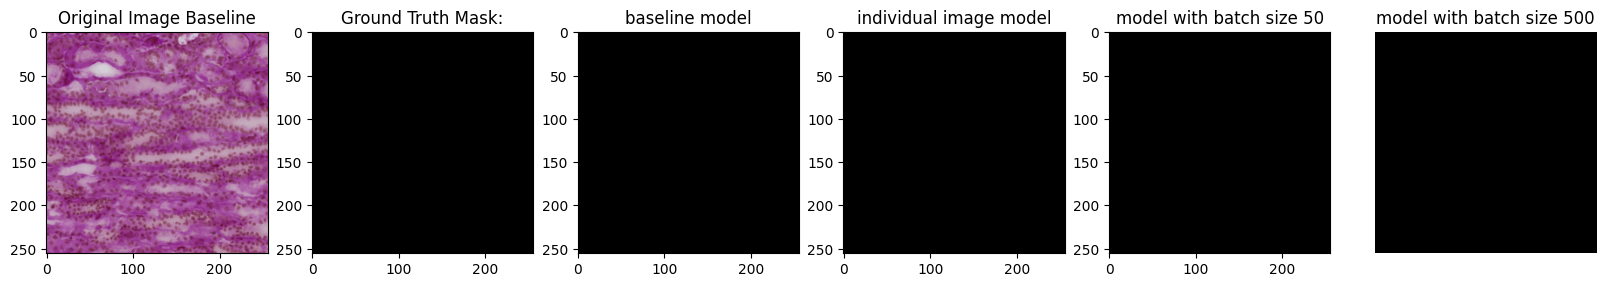

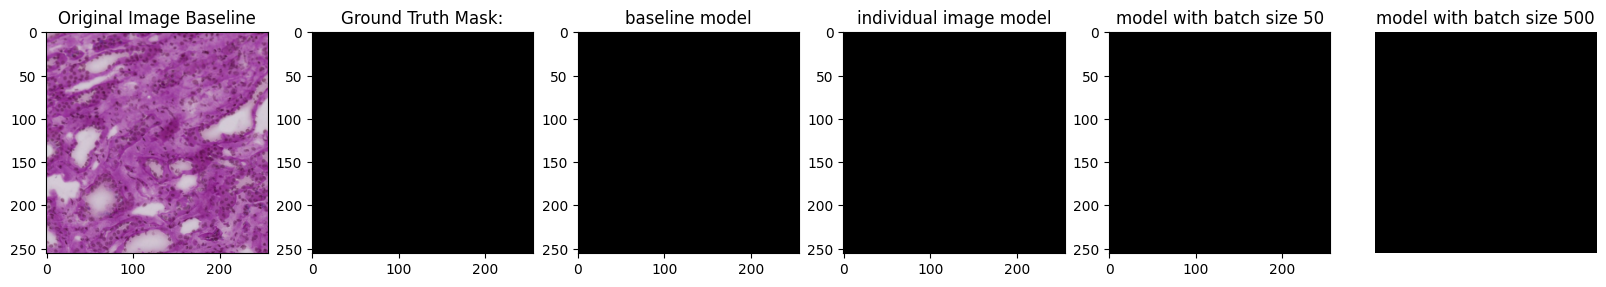

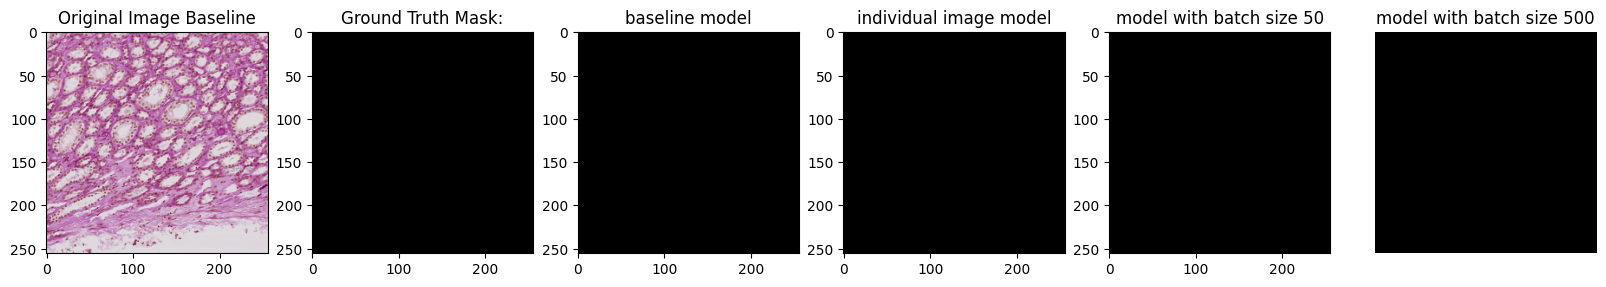

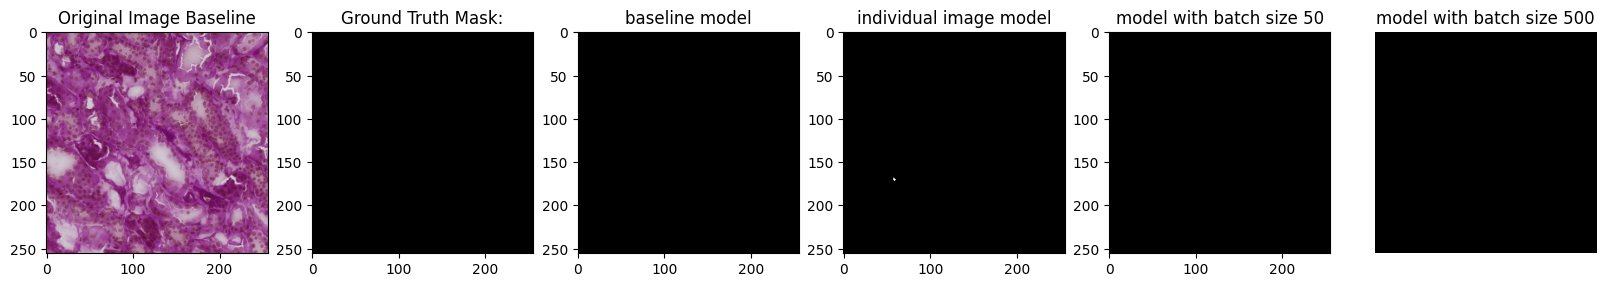

In [ ]:
#in actual case scenario we cannot run prediction considering batch of images, so testign how it performs
import matplotlib.pyplot as plt
for j in range(len(image_baseline)):
    original_image_baseline=image_baseline[j]
    original_image_individual=image_individual[j]
    original_image_batch50=image_batch50[j]
    original_image_batch500=image_batch500[j]

    predicted_mask_baseline = baseline_model.predict(image_baseline[j])
    predicted_mask_individual=model_individual.predict(image_individual[j])
    predicted_mask_batch50=model_batch50.predict(image_batch50[j])
    predicted_mask_batch500=model_batch500.predict(image_batch500[j])

    predicted_mask_baseline = (predicted_mask_baseline > 0.5).astype(np.uint8)
    predicted_mask_individual = (predicted_mask_individual > 0.5).astype(np.uint8)
    predicted_mask_batch50 = (predicted_mask_batch50 > 0.5).astype(np.uint8)
    predicted_mask_batch500 = (predicted_mask_batch500 > 0.5).astype(np.uint8)
    mask=mask_baseline[j]

    for i in range(predicted_mask_baseline.shape[0]):
          count=count+1
          predicted_mask_baseline_i=np.max(predicted_mask_baseline[i],axis=-1)
          predicted_mask_baseline_i = predicted_mask_baseline_i * 255

          predicted_mask_individual_i=np.max(predicted_mask_individual[i],axis=-1)
          predicted_mask_individual_i = predicted_mask_individual_i * 255

          predicted_mask_batch50_i=np.max(predicted_mask_batch50[i],axis=-1)
          predicted_mask_batch50_i = predicted_mask_batch50_i * 255

          predicted_mask_batch500_i=np.max(predicted_mask_batch500[i],axis=-1)
          predicted_mask_batch500_i = predicted_mask_batch500_i * 255

          masks=np.max(mask[i],axis=-1)

          # Plot the original image, mask, and predicted mask
          plt.figure(figsize=(20, 20))
          plt.subplot(1, 6, 1)
          plt.imshow(original_image_baseline[i])
          plt.title("Original Image Baseline")

          


          plt.subplot(1, 6, 2)
          plt.imshow(masks,cmap='gray')
          plt.title("Ground Truth Mask:")


          plt.subplot(1, 6, 3)
          plt.imshow(predicted_mask_baseline_i, cmap="gray")
          plt.title("baseline model")


          plt.subplot(1, 6, 4)
          plt.imshow(predicted_mask_individual_i, cmap="gray")
          plt.title("individual image model")


          plt.subplot(1, 6, 5)
          plt.imshow(predicted_mask_batch50_i, cmap="gray")
          plt.title("model with batch size 50")


          plt.subplot(1, 6, 6)
          plt.imshow(predicted_mask_batch500_i, cmap="gray")
          plt.title("model with batch size 500")
          plt.axis("off")

          plt.show()



In [ ]:
#implementing confusion matrix:
import numpy as np
from sklearn.metrics import confusion_matrix
true_masks=[]
predicted_masks=[]
count=0
for image,mask in test_dataset:
    count=count+1
    predicted_mask_baseline = model_batch500.predict(image)
    predicted_mask_baseline = (predicted_mask_baseline > 0.5).astype(np.uint8)
    true_masks.append(np.max(mask, axis=-1).flatten())  # Convert one-hot encoded mask to integer label
    predicted_masks.append(np.argmax(predicted_mask_baseline, axis=-1).flatten())
    


In [ ]:

TP=0
FP=0
TN=0
FN=0
for i in range(len(true_masks)):
    TP += np.sum(np.logical_and(predicted_masks[i], true_masks[i]))
    FP += np.sum(np.logical_and(predicted_masks[i], np.logical_not(true_masks[i])))
    TN += np.sum(np.logical_and(np.logical_not(predicted_masks[i]), np.logical_not(true_masks[i])))
    FN += np.sum(np.logical_and(np.logical_not(predicted_masks[i]), true_masks[i]))

In [ ]:
print("TP",TP)
print("FP",FP)
print("TN",TN)
print("FN",FN)
accuracy=(TP + TN) / (TP + FP + TN + FN)
print("the accuracy is",accuracy)

TP 126859
FP 96962
TN 109771624
FN 3119691
the accuracy is 0.971563018763466


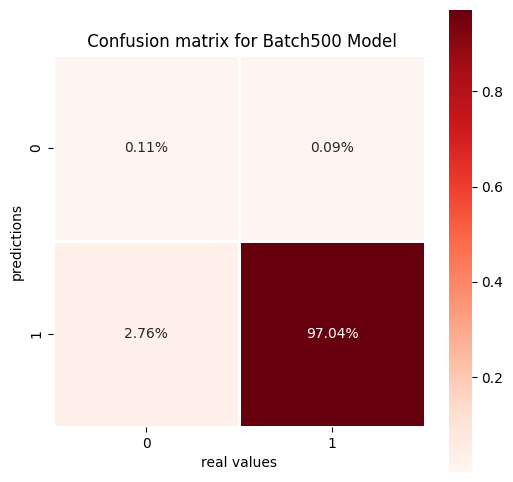

In [ ]:
cmat = [[TP, FP], [FN, TN]]
import seaborn as sns
plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.xlabel("real values")
plt.ylabel("predictions")
plt.title(" Confusion matrix for Batch500 Model")
plt.show()